# Health Information Systems and Decision Support Systems
# WPO 5: - CAD Systems (15/03/2024)
***
*Panagiotis Gonidakis, Jakub Ceranka, Joris Wuts, Jef Vandemeulebrouke*<br>
*Department of Electronics and Informatics (ETRO)*<br>
*Vrije Universiteit Brussel, Pleinlaan 2, B-1050 Brussels, Belgium*

<font color=blue>Aline Jacquart - 0567936 <br>
                 César Zapata - 0596811</font>

### Goal
The goal of this practical session is to get an insight into artificial neural networks, more specifically multi-layer perceptrons (MLP) and convolutional neural networks (CNN). Your tasks will involve:
- examining and pre-processing the real life lung nodule CT data
- training various neural networks with increasing complexity to classify if there is a lung nodule on the CT image
- validating the performance of your system against the manual ground-truth predictions prepared by an experienced radiologist.
- visualizing training graphs and analysing information about model performance

Students must send their notebook (and `wandb` generated report for all models in `pdf`) using the Assignment functionaly of Canvas before <b> 21/03/2024, 23:59 pm. </b>, in `.ipynb` and `.html` format. The grade from this practical session will contribute to your final grade.

Questions: [jceranka@etrovub.be](mailto:jceranka@etrovub.be), [jwuts@etrovub.be](mailto:jwuts@etrovub.be)

# Libraries
During this practical session, the following libraries will be used:

* Numpy (np)
* Glob
* Simple ITK (sitk)
* Matplotlib
* Sklearn
* Tensorflow (tf)
* Keras (you can also use pytorch if you are more familiar)
* wandb

To import any external library, you need to import it using the **import** statement followed by the name of the library and the shortcut. You can additionally check for the module version using **version** command.

* If you use your own laptop, you will need to install new modules.

* These expirements are simplified in order to be run without the need of a powerful GPU. However some training tasks may take 30-40 minutes using a CPU. You can accelerate your expirements if you work on [Google colab](https://colab.research.google.com/) framework where a GPU is offered. Then you need to create a GoogleDrive account and upload all the necessary data (scripts + data).
For more information look [here](https://colab.research.google.com/) and [here](https://colab.research.google.com/notebooks/gpu.ipynb).

### Tensorflow and Keras

TensorFlow (https://www.tensorflow.org/) is an end-to-end open-source platform for machine learning. It’s a comprehensive and flexible ecosystem of tools, libraries and other resources that provide workflows with high-level APIs. The framework offers various levels of concepts for you to choose the one you need to build and deploy machine learning models.

Keras (https://keras.io/), on the other hand, is a high-level neural networks library that is running on the top of TensorFlow. Using Keras in deep learning allows for easy and fast prototyping as well as running seamlessly on CPU and GPU. This framework is written in Python code which is easy to debug and allows ease for extensibility. Keras offers simple and consistent high-level APIs and follows best practices to reduce the cognitive load for the users. Both frameworks provide high-level APIs for building and training models with ease. Keras is built in Python which makes it way more user-friendly than TensorFlow.

In this exercise, <b>we recommend to use Keras</b> which allows to create/train/test neural networks with very few lines of understandable code.

Keras requires Tensorflow to be installed. Normally, the new versions of Keras installs it automatically.

To install Keras, open the anaconda prompt and then type:
 ```pip install keras```
    
If not done automatically:
 ```pip install tensorflow``` and after ```pip install keras```

To start using visualization platform Weights-And-Biases go to (https://wandb.ai/) and create an account. Locally do: ```pip install wandb```


Here are some useful resources (installation + documentation):

* https://phoenixnap.com/kb/how-to-install-keras-on-linux <p>
* https://www.tensorflow.org/install <p>
* https://keras.io/getting_started/ <p>
* https://keras.io/api/models/ <p>
* https://keras.io/api/models/sequential/ <p>
* https://docs.wandb.ai/quickstart <p>
    
(*) For the purpose of this exercise, you don't need to use a GPU; tensorflow and keras can be configured to run on a CPU and the most demanding training tasks should not take more than 30 min. On the other hand, [colab](https://colab.research.google.com/) offers GPU development environment and the training tasks can really be accelerated.

(*) Make sure you are using tensorflow 2. It is advised to verify which version it is being used before looking for any documentation as the APIs differ.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# this is just the path in my drive for the WPO folder
%cd drive/MyDrive/UGent/Health-info-and-support/WPO-5/
%ls

/content/drive/MyDrive/UGent/Health-info-and-support/WPO-5
images/            screenshots_tensorboard/  train_data.npy
__MACOSX/          test_data.npy             train_labels.npy
MiniLunaDataset3/  test_labels.npy           WPO5_AlineJacquart_CesarZapata_2024.ipynb


# Lung Nodule Analysis
Lung cancer is the leading cause of cancer-related deaths worldwide. Screening high risk individuals for lung cancer with low-dose CT scans is now being implemented in the United States and other countries are expected to follow soon. In CT lung cancer screening, millions of CT scans will have to be analyzed, which is an enormous burden for radiologists. Therefore, there is a lot of interest in development of computer algorithms to optimize cancer screening.

<img src="images/luna16_image.png">

A vital first step in the analysis of lung cancer CT scans is the detection of pulmonary nodules, which may or may not represent early stage lung cancer. Many computer-aided detection (CAD) systems have already been proposed for this task.

The LIDC/IDRI data set is publicly available, including the ground-truth annotations of nodules performed by four radiologists.

This practical session is inspired from the challenge [LUNA16](https://luna16.grand-challenge.org/home/), which focused on a large-scale evaluation of automatic nodule detection algorithms on the LIDC/IDRI data set.

<img src="images/lung_cancer1.png">


### Using LIDC/IDRI data set in this practical session

For the needs of this practical session, we will look for an algorithm that only determines the likelihood for a given location in a CT scan to contain a pulmonary nodule. Furthermore, we have included a very small part of the LIDC/IDRI data set and we will use only a slice of suspicious regions of a CT scan.

### Data augmentation

Originally our dataset was very unbalanced. There were a lot samples of non-nodules (negatives) but very few samples of nodules (positives). Machine learning algorithms and specifically neural networks and convolutional neural networks require to be trained on balanced dataset, meaning all the classes should be equally represented in the training set.

Using data augmentation methods (**rotation and translation**), positive samples were massively augmented in order to balance the two classes (nodules and non-nodules)

### Ground Truth data

Categorical data are variables that contain label values rather than numeric values. In our dataset, a sample can represent a nodule or a non-nodule area, so initially we have our ground truth data in a categorical form. Many machine learning algorithms cannot operate on label data directly. They require all input variables to be numeric. This means that categorical data must be converted to a numerical form. This involves two steps:
1. Integer Encoding
2. One-Hot Encoding.

As a first step, each unique category value is assigned an integer value. That's why in our dataset, a sample which represents a nodule will have as a label `1` and a sample which represents a non-nodule area will have as a label `0`.

For our case, this enconding step would be enough since we have only two categories. However, in a more general problem with more than two classes, using this encoding allows the model to assume a natural ordering between categories which may result in poor performance or unexpected results. That's why, one hot encoding can be appled to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

Therefore, a  nodule will be represented by the binary variable `[1,0]` and a non-nodule area by the binary variable `[0,1]`.

<img src="images/lung_cancer2.png">


# Part 1: Visualize, load and prepare data for Machine Learning Algorithms

CT images are stored in MetaImage (`mhd/raw`) format. Each .mhd file is stored with as a header file (`.mhd`) and a corresponding pixeldata file (`.raw`). To load a CT image, just **load the `.mhd` header file** and data from the binary .raw file will be automatically loaded.

If you look carefully at the name of each .mhd file, you can extract useful information for a specific sample. You can identify its **number id**, its **size**, if the image was produced by a **data augmentation** method and if it contains a **nodule or not**.

For example: *20046_x0y0z0_20x20x6_r0_1.mhd*
* **20046**:   number of candidate patch
* **x0y0z0**: no translation in any axis (if augmentation is used it is mentioned by the angle in the corresponding axis)
* **20x20x6**: size of the image in voxels
* **r0**:     no rotation
* **1**:      it is a positive sample - represents a nodule
* **.mhd**:   it is a mhd file (this is the file which can be loaded)

### Task 1: Import necessary libraries

Load all necessary libraries using the **import** statement and check for errors.

In [ ]:
!pip install SimpleITK
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00


In [1]:
# Code for Part 1: Task 1
import os
import re
import glob
import keras
import wandb
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import SimpleITK as sitk
from matplotlib import pyplot as plt

%ls


 Volume in drive C has no label.
 Volume Serial Number is 2F80-015A

 Directory of c:\Users\cesar\Documents\UGent\2023-2024\Second-term\Health-Information-and-Decision-Support-Systems\Health-Information\WPO-5

19/03/2024  17:07    <DIR>          .
15/03/2024  09:02    <DIR>          ..
15/03/2024  09:21    <DIR>          __MACOSX
15/03/2024  09:21    <DIR>          images
15/03/2024  09:19    <DIR>          MiniLunaDataset3
15/03/2024  09:21    <DIR>          screenshots_tensorboard
15/03/2024  09:19           742.528 test_data.npy
15/03/2024  09:20             3.840 test_labels.npy
15/03/2024  09:20         6.665.728 train_data.npy
15/03/2024  09:20            33.456 train_labels.npy
19/03/2024  17:07            60.211 WPO5_AlineJacquart_CesarZapata_2024.ipynb
               5 File(s)      7.505.763 bytes
               6 Dir(s)  276.705.865.728 bytes free


### Task 2: Inspect the dataset

1. Using `SimpleITK`, create a function to load `.mhd` files (__Tip:__ The function should return a numpy array - `sitk.GetArrayFromImage( )`)
2. Visualize the 6 slices of a chosen patch using `matplotlib` subplot figure and mention if it is a positive or a negative patch (Use colorscale `gray`)
3. Visualize some augmented samples from the same candidate region using `matplotlib` subplot of the same patch and mention the augmentation method. Check visually if the observed patch was modified using the same augmentation method that is mentioned in the samples' filename.
4. Count your files. How many positives and negatives there are in this dataset? (__Tip:__ Use `glob` library to get the number of specific files in your dataset).

In [7]:
%ls

 Volume in drive C has no label.
 Volume Serial Number is 2F80-015A

 Directory of c:\Users\cesar\Documents\UGent\2023-2024\Second-term\Health-Information-and-Decision-Support-Systems\Health-Information\WPO-5

19/03/2024  17:07    <DIR>          .
15/03/2024  09:02    <DIR>          ..
15/03/2024  09:21    <DIR>          __MACOSX
15/03/2024  09:21    <DIR>          images
15/03/2024  09:19    <DIR>          MiniLunaDataset3
15/03/2024  09:21    <DIR>          screenshots_tensorboard
15/03/2024  09:19           742.528 test_data.npy
15/03/2024  09:20             3.840 test_labels.npy
15/03/2024  09:20         6.665.728 train_data.npy
15/03/2024  09:20            33.456 train_labels.npy
19/03/2024  17:11            63.956 WPO5_AlineJacquart_CesarZapata_2024.ipynb
               5 File(s)      7.509.508 bytes
               6 Dir(s)  276.696.961.024 bytes free


c:\Users\cesar\Documents\UGent\2023-2024\Second-term\Health-Information-and-Decision-Support-Systems\Health-Information\WPO-5\20046_x-1y0z0_20x20x6_f0_1.mhd
True
MiniLunaDataset3\20046_x-1y0z0_20x20x6_f0_1.mhd


TypeError: Invalid shape (6, 20, 20) for image data

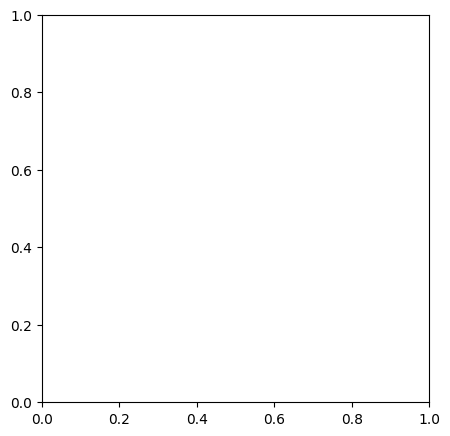

In [21]:
# path = "drive/MyDrive/UGent/Health-info-and-support/WPO-5/"
# print(os.path.abspath('drive/MyDrive/UGent/Health-info-and-support/WPO-5/25637_x0y0z-1_20x20x6_q270_1.mhd'))
print(os.path.abspath('20046_x-1y0z0_20x20x6_f0_1.mhd'))
print(os.path.isfile("MiniLunaDataset3\\20046_x-1y0z0_20x20x6_f0_1.mhd"))
print(os.path.join('MiniLunaDataset3', '20046_x-1y0z0_20x20x6_f0_1.mhd'))
image = sitk.ReadImage(os.path.join('MiniLunaDataset3', '20046_x-1y0z0_20x20x6_f0_1.mhd'))
plt.figure(figsize=(5, 20))
plt.imshow(sitk.GetArrayFromImage(image), cmap=plt.cm.Greys_r)

6
['20046_x-1y0z0_20x20x6_f0_1.mhd', '20046_x-1y0z0_20x20x6_f180_1.mhd', '20046_x-1y0z0_20x20x6_f270_1.mhd', '20046_x-1y0z0_20x20x6_f90_1.mhd', '20046_x-1y0z0_20x20x6_q0_1.mhd', '20046_x-1y0z0_20x20x6_q180_1.mhd']


TypeError: Invalid shape (2400,) for image data

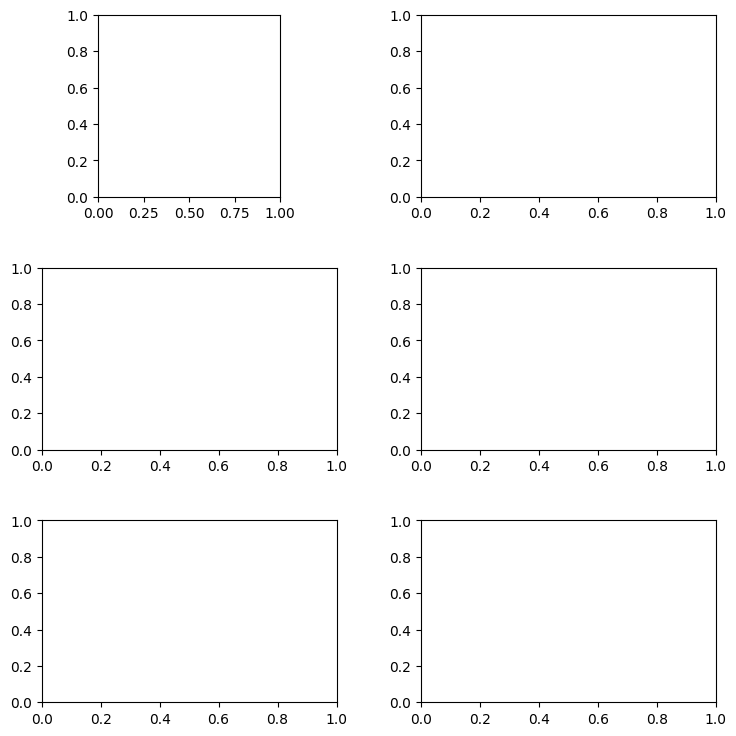

In [18]:
# Code for Part 1: Task 2
def loadImage(filename):
    image = sitk.ReadImage(filename)
    return image

def showImages(images):
    # plt.figure(figsize=(5, 20))
    # plt.imshow(sitk.GetArrayViewFromImage(image), cmap=plt.cm.Greys_r)
    arr_images = []
    for image in images:
      arr_images.append(loadImage(f"MiniLunaDataset3/{image}"))

    # plotting images with corresponding histograms
    figs, axs = plt.subplots(3, 2, figsize=(8, 8))
    figs.tight_layout(pad=3.0)

    axs[0][0].imshow(arr_images[0], cmap='grey')
    axs[0][0].set_title(f"{images[0]}")

    axs[0][1].imshow(arr_images[1], cmap='grey')
    axs[0][1].set_title(f"{images[1]}")

    axs[1][0].imshow(arr_images[2], cmap='grey')
    axs[1][0].set_title(f"{images[2]}")

    axs[1][1].imshow(arr_images[3], cmap='grey')
    axs[1][1].set_title(f"{images[3]}")

    axs[2][0].imshow(arr_images[4], cmap='grey')
    axs[2][0].set_title(f"{images[4]}")

    axs[2][1].imshow(arr_images[5], cmap='grey')
    axs[2][1].set_title(f"{images[5]}")

    plt.show()

# looking for the images in the patch: trying patch 25637
dir_path = 'MiniLunaDataset3'
files = os.listdir(dir_path)
patch = '20046'

images_arr = []
# a ver como es la vuelta pues
for file in files:
  if len(images_arr) >= 6: break
  if patch in file and 'mhd' in file:
    images_arr.append(file)

print(f"{len(images_arr)}\n{images_arr}")

showImages(images_arr)

### Task 3: Data pre-processing
In order to use neural-networks, we need to pre-process the data and store it in a way which can be easily interpreted by keras.

First of all, separate the test set from the train set. Keep 10% of your samples as a test-set. (**Tip:** Use `sklearn` `train_test_split` function.)

Since 3D CNNs need a lot of computation power, we will convert our problem to 2D. Instead of using all the 6 CT slices, we will use only the 3rd CT slice. Therefore, from each sample, the 3rd slice wiil be extracted and further preprocessed. In addition, our values currently range from -1024 HU to around 2000 HU. Anything above 400 is not interesting to us, as these are simply bones with different radiodensity. A commonly used set of thresholds to normalize between is -1000 and 400. Finally the labels will be properly encoded to be used for training and testing.

Write your pre-processing tasks as python functions (listed below) and in the end create a pipeline for each sample which will be also implemented as a function.
1. Function loading the `.mhd` image as a numpy array.
2. Function extracting the 3rd slice of a patch. The final form of patches should be a numpy array of size **20x20** pixels.
3. Function normalizing the dataset.
The unit of measurement in CT scans is the **Hounsfield Unit (HU)**, which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this. From Wikipedia:
<img src="images/HU_CTscannersCalibration.png">

    Create a function which is going to normalize the samples according to this table
        * Create numpy arrays
        * Normalize between [-1000, 400] using this normalization method
    $npzarray = (npzarray - minHU) / (maxHU - minHU)$ <br>
         where minHU = -1000 and maxHU = 400
        * After this normalization set any values bigger than 1 to 1 and any values smaller than 0 to 0.

4. Write an `If statement` encoding a label into a **1-hot** label as a ground-truth data in order to train the neural networks. (One-hot labels: `[0,1]` --> negative, `[1,0]` --> positive)

5. Store into `.npy` data binary files. (__Tip:__ Use `np.save` to store data.)

The pipeline should execute the functions as follows: <br>

- Use `train_test_split` to divide the dataset into train and test subsets. Do that on patient level!
- Create empty `np.arrays` filled with zeros to store patches and label data
- Use for loop to iterate over all images in a train set:
    - Load `.mhd` using `sitk`
    - Normalize
    - Extract 3rd slice
    - Extract label as one-hot.
    - Insert into empty array at correct index location
- Save dataset.
- Repeat for a test set.

and return:
* data:  [sample_idx,20,20]
* labels: [sample_idx,2]

Data pre-processing should be done for both: train and test set.

In [ ]:
# Code for Part 1: Task 3

In case you are not able to complete Part 1, you can move to Part 2 of the session by loading the provided `.npy` files. In that case you will **not** get any credits for Part 1.

# Part 2: Model training and validation

### Using Keras - A High Level API for Tensorflow

Keras introduces a High-Level API that makes neural network building and training fast and easy. This API is intuitive and fully compatible with Tensorflow. In addition, keras provides a plethora of [APIs](https://keras.io/api/models/) and the user may select one that meets his needs. For the purpose of this exercise, the [sequential model](https://keras.io/api/models/sequential/) can be employed.

### Visualization of training curves with `wandb`

For the purpose of visualization in real-time the performance of our training, you will use Weights-And-Biases (`wandb`). During or after training you can use  it  to visualize the network and its performance. <b> For  all the following training tasks you are requested to include the loss and the accuracy graphs for training and also for evaluating the test-set</b>. A simple way to attach these graphs to jupyter notebook is to use generate a report after the training of all your networks is finished. Please upload that report in the pdf format and upload it in yur submission together with this notebook.

Have a look at the following links for some tutorials on first use and report generation in `wandb`:
* https://docs.wandb.ai/quickstart
* https://docs.wandb.ai/guides/reports/create-a-report

### Some Tips:

* Use ```np.load``` to load your data from the previously created .npy binary files.
* Use ```reshape``` method when it is needed to import data to the network.
* Make your own function to create the model for each network architecture to avoid any model conflicts.

* If you trained a model in a past python session, you can load the trained model but first you have to <b>define and initialize it again</b>.

* Use `wandb` to visualize network and performance:

* If you have strange keras errors, restart the python kernel and <b> re-run only the cells concerning your task you currently work (i.e. run the cells concerning only the current keras). Sometimes you cannot load two different keras at the same python session.</b>.

(*) Depending the version of tensorflow you are working some commands might differ. Please look online for recent documentation.

### Task 1: Load Data from the numpy binary files (from Part 1)
Use the `numpy` load function to load the data created in the previous part of the exercise. The data has to be reshaped in a specific way (use code below) in order to be compatible with the keras neural network input standard. After the data is successfully loaded, plot any patch and its ground-truth as image title to verify that data is correctly represented.

In [ ]:
# Code for Part 2: Task 1

X = train_data.reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_val = test_data.reshape(-1,IMG_SIZE,IMG_SIZE,1)

### Task 2: Artificial Neural Networks (1 layer)
First, lets train our classifier using an artificial neural network with just one layer (perceptron), a fully connected one (dense). This layer will have `softmax` as activation function and only two neurons.

The main advantage of using this activation function is the output range. The range of the outputs will be `[0,1]` and the sum of all the probabilities will be equal to one. Generally, if the softmax function is used for a  multi-classification model it returns the probabilities of each class and the target class will have higher probability.

Using Keras, define your model. Use these hyperparameters:
* Learning Rate = `1e-4`
* Batch Size = `8`
* Optimizer = `sgd`
* Loss metric = `categorical_crossentropy`
* Validation metric score in Keras = `accuracy`

Check your model architecture with `summary()` function.

Since the network is small, it is not recommended to use `Dropout`. Train first for 1-2 epochs to verify that everything works and then train for ~10 epochs. To automatically integrate `wandb` in your Keras `model.fit` function, import `from wandb.keras import WandbMetricsLogger` and add a callback statement: `callbacks=[WandbMetricsLogger()]`. Observe the training and evaluate graphs from `wandb` to decide when to stop training.

To evaluate the trained model, test it with the test samples (use `validation_data` in `model.fit` function).

### Tip:
* Use `.Flatten()` layer first to create a 1D vector in your input layer.
* It is highly recommended to write all the tasks in functions and have as an input argument your keras. Then you will be able to re-use them in the next tasks for different keras.

In [ ]:
# Code for Part 2: Task 2

### Task 3: Test the model
In this section you are going to write a <b>generic</b> validation function to assess the performance of out trained models. To do so, we will need the following modules from `sklearn`:
- `confusion_matrix`
- `accuracy_score`
- `roc_curve`

Import the modules and create a `python` function which takes two input arguments (validation test data and its GT labels). Use `model.predict` method to predict the class of our test set. Using the function print the `confusion_matrix`, `accuracy_score` and a `roc_curve` of this specific model.

Use to function to assess the performance of your first train model. Print all of the validation metrics and a ROC curve.

__Hint__: For the calculation of `confusion_matrix` and `accuracy_score` you need to transform your predicted and GT labels using `np.argmax`.

__Hint__: For the calculation of `roc_curve` take only the second column of the predicted one-hot label e.g. `test_preds = test_preds[:,1]`

Explain these graphs and the ROC curve. What role does the decision threshold play and why it is so important? Can we have a single value as the decision threshold? Why?

In [ ]:
# Answer to the question

In [ ]:
# Code for Part 2: Task 3

### Task 4.1: Artificial Neural Networks (3 layers) - Let's go deep!

From now on, we will try various networks with increasing complexity. Make sure with every network/parameter change, you update any hyperameters; you test and evaluate the new model with the previously used evaluation metrics (ROC curve, confusion matrix...). Moreover, every time check the training curves in `wandb`.

Let's try 3 fully-connected layers using `sigmoid` activation function.

Here is an example network but you are free to choose your own network.
* 1st dense layer with 80 neurons, `sigmoid` activation
* 2nd dense layer with 40 neurons, `sigmoid` activation
* 3rd dense layer with 2 neurons and `softmax` activation
* optimizer: `sgd`
* learning rate: `1e-4`

Explain your network's architecture and **test** your system as you did for the previous simple neural network. What do you observe? Make sure you tune again any hyperparameters like the amount of training epochs. Choose different values for the learning rate, number of epochs and batch size (e.g. 10, 20, 30...). Can you find some training curves which indicate **underfitting** and **overfitting**? If so, what network parameters play a crucial role in observing **underfitting** or **overfitting**?

**Remark:** Some deeper models require more training to reach their optimal performance. If possible with your computational resources, try to train them for more epochs until no increase in accuracy is observed.

In [ ]:
# Answer to the question

In [ ]:
# Code for Part 2: Task 4.1

### Task 4.2: Relu!
RELU = Rectified Linear Unit

Let's try the same network but using RELU instead of sigmoid now.

In [ ]:
# Code for Part 2: Task 4.2

### Task 4.3: Dropout!
Now lets add two dropout layers (each after the dense layer with relu activation). Some recommended values to investigate are 0.9, 0.5, 0.1. Explain the results.

In [ ]:
# Your answer here

In [ ]:
# Code for Part 2: Task 4.3

### Task 5. A Convolutional Neural Network

Finally, we are going to implement a convolutional neural network - a network type showing state-of-the-art results in learning from images. This time, your input will not be flattened but we will provide a 2D image as an input (20x20x1 pixels). Use the same hyperparameters as before, unless specified differenly.

#### Model definition

input -> conv1 -> pool1 -> conv2 -> dense1 -> dense2 -> softmax
* convolution layers: kernel size = 3x3, number of channels = 64, activation function = sigmoid
* max-pooling layers: kernel size = 2x2, strides = 2
* 1st dense layer: 50 neurons, activation function = sigmoid
* 2nd dense layer: 2 neurons, activation function = softmax
* optimizer = `sgd`
* use dropout (e.g. 0.2)

__Hint__: Use `.Flatten()` after before the dense layers to ensure a 1D vector as an input.

Like before, measure system's prerfomance and explain.

In [ ]:
# Code for Part 2: Task 5

### Task 6. A Deeper Convolutional Neural Network

#### Model definition

input -> conv1 -> pool1 -> conv2 -> conv3 -> fc1 -> fc2 -> softmax
* convolution layers: kernel size = 5x5, number of channels = 64, activation function = 'relu', padding = 'same'
* max-pooling layers: kernel size = 2x2, strides = 2
* 1st fully connected: 100 neurons, activation function = relu
* 2nd fully connected: 2 neurons, activation function = softmax
* optimizer = `sgd` (try also `adam`)
* use dropout (e.g. 0.5)

Like before, measure system's prerfomance and explain.

This was the last model you have trained. The `wandb` should now allow you to generate a common report for all train models (on the same graphs). Generate the report, download it as a `pdf`, and upload it in your assignment together with the notebook file.

In [ ]:
# Code for Part 2: Task 6